<a href="https://colab.research.google.com/github/liliya-ily/cancer_densnet/blob/main/Xception_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lilyily","key":"81676af7d82503252c257212cf373319"}'}

In [4]:
! mkdir ~/.kaggle

In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 93% 301M/325M [00:01<00:00, 176MB/s]
100% 325M/325M [00:01<00:00, 201MB/s]


In [ ]:
! unzip skin-cancer-malignant-vs-benign.zip -d Cancer 

In [10]:

import os
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import os
from torchvision import transforms
from sklearn.metrics import roc_curve, auc

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
image_size = (220, 220)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Cancer/data/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Cancer/data/test",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2637 files belonging to 2 classes.
Using 2110 files for training.
Found 660 files belonging to 2 classes.
Using 132 files for validation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


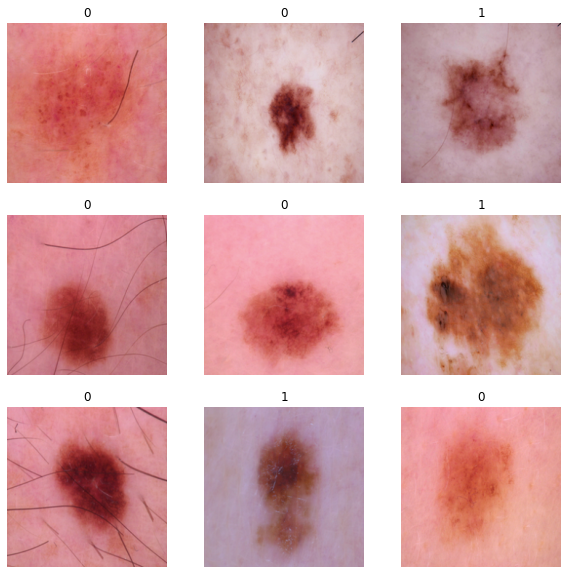

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(4):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


In [20]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
valind_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=10)


In [36]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.5),
    ]
)


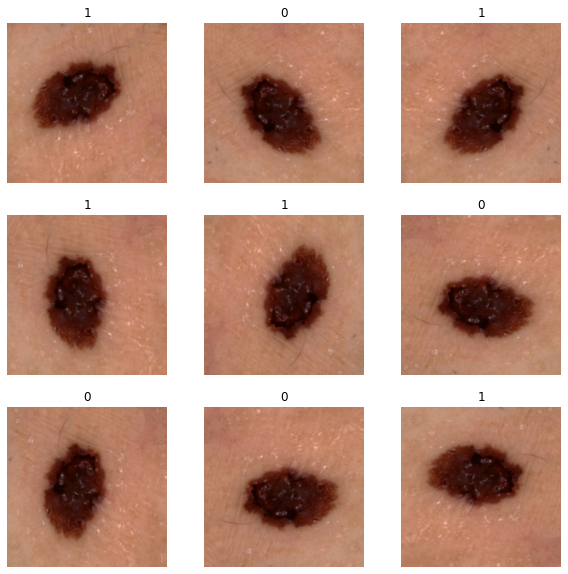

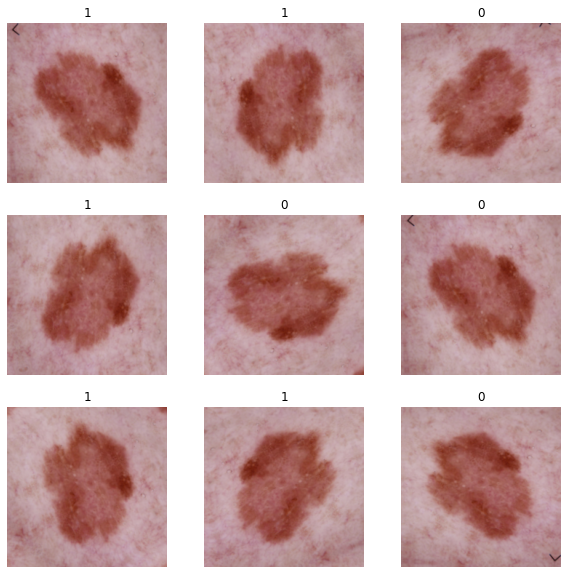

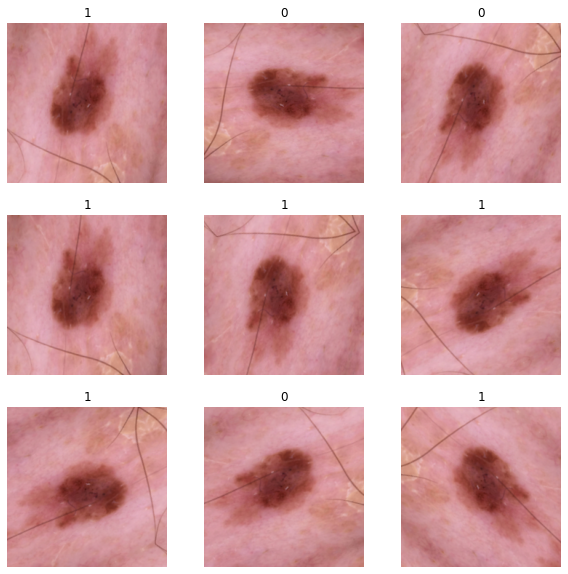

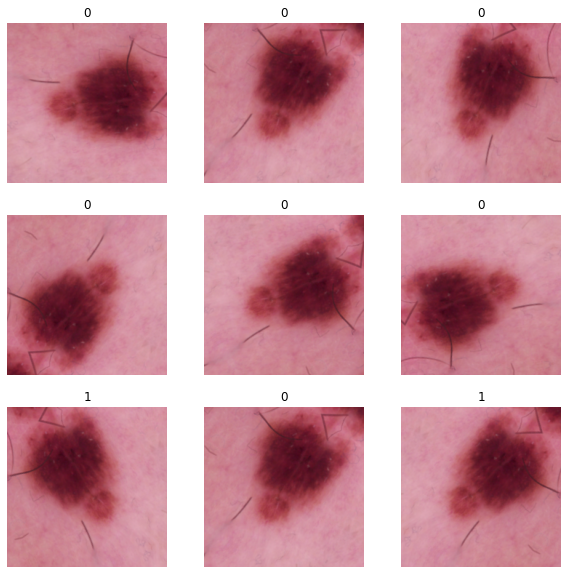

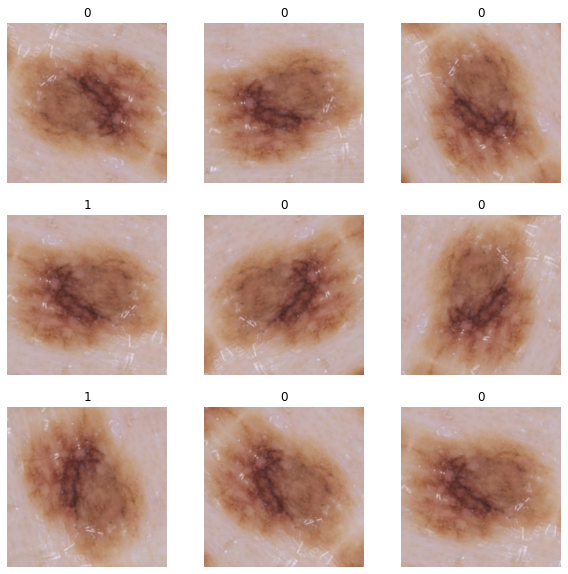

In [37]:
import numpy as np

for images, labels in train_ds.take(5):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")



Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 220, 220, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 220, 220, 3)       0         
_________________________________________________________________
normalization_27 (Normalizat (None, 220, 220, 3)       7         
_________________________________________________________________
densenet169 (Functional)     (None, 6, 6, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_25  (None, 1664)              0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 1664)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 25)                416

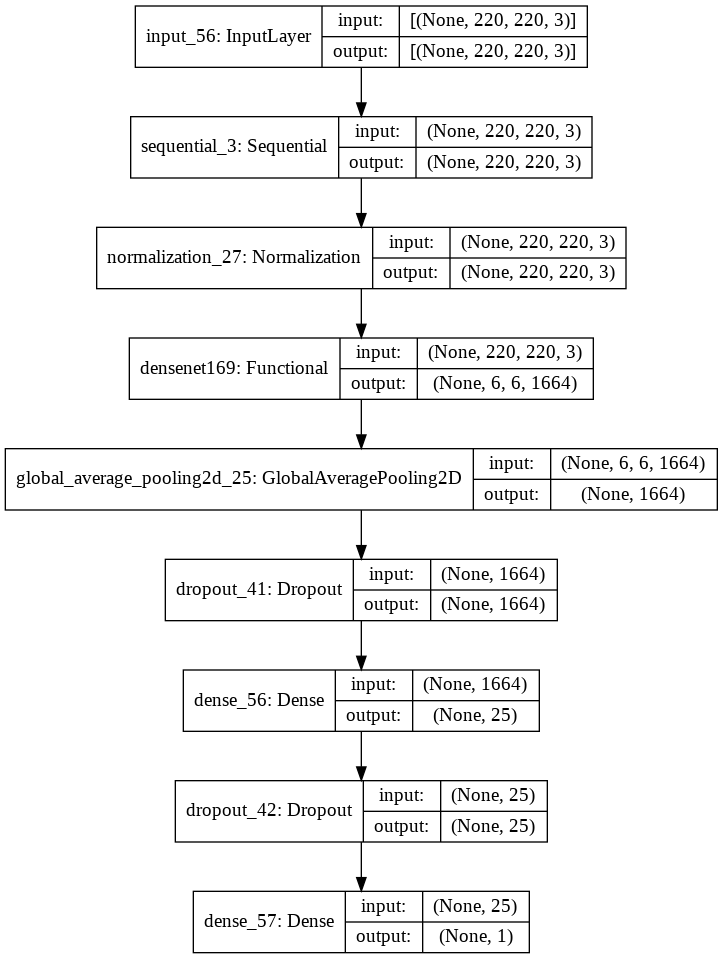

In [117]:
base_model = keras.applications.DenseNet169(
    weights="imagenet",  # Берем веса, полученные на ImageNet.
    input_shape=(220, 220, 3),
    include_top=False,
)  # Отключаем дефолтный классификатор .

# Указываем, что тренировать Xception не надо
base_model.trainable = False

# Делаем свой входной плейсхолдер
inputs = keras.Input(shape=(220, 220, 3))
x = data_augmentation(inputs)  # Применяем аугментацию


norm_layer = keras.layers.experimental.preprocessing.Normalization( )
mean = np.array([127.5, 127.5, 127.5])
var = mean ** 2

# Стандартизируем
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# Добавляем слой пулинга и дропаута
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.7)(x) 

# previous_block_activation = x  # Set aside residual
# for size in [128]:
#      x = layers.Activation("relu")(x)
#      x = layers.BatchNormalization()(x)
#     #    # Project residual
#      residual = layers.Dense(1664)(
#          previous_block_activation
#      )
#      x = layers.add([x, residual])  # Add back residual
#      previous_block_activation = x  # Set aside next residual

#      x = layers.BatchNormalization()(x)
#      x = layers.Activation("relu")(x)

x = keras.layers.Dense(25)(x)
x = keras.layers.Dropout(0.2)(x) 

outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

keras.utils.plot_model(model, show_shapes=True)

In [119]:
base_model.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.0005),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [120]:
epochs = 50

results = model.fit(train_ds, 
                    epochs=epochs, 
                    validation_data=val_ds)


Epoch 1/50
66/66 [==============================] - 54s 545ms/step - loss: 0.8025 - binary_accuracy: 0.5246 - val_loss: 0.6827 - val_binary_accuracy: 0.5000
Epoch 2/50
66/66 [==============================] - 31s 468ms/step - loss: 0.5612 - binary_accuracy: 0.6725 - val_loss: 0.4808 - val_binary_accuracy: 0.6515
Epoch 3/50
66/66 [==============================] - 31s 467ms/step - loss: 0.5417 - binary_accuracy: 0.6915 - val_loss: 0.4038 - val_binary_accuracy: 0.8258
Epoch 4/50
66/66 [==============================] - 31s 469ms/step - loss: 0.4571 - binary_accuracy: 0.7555 - val_loss: 0.3971 - val_binary_accuracy: 0.7121
Epoch 5/50
66/66 [==============================] - 31s 467ms/step - loss: 0.4202 - binary_accuracy: 0.7607 - val_loss: 0.3865 - val_binary_accuracy: 0.8333
Epoch 6/50
66/66 [==============================] - 31s 471ms/step - loss: 0.4108 - binary_accuracy: 0.7839 - val_loss: 0.3977 - val_binary_accuracy: 0.8182
Epoch 7/50
66/66 [==============================] - 31s 46

До разморозки графики

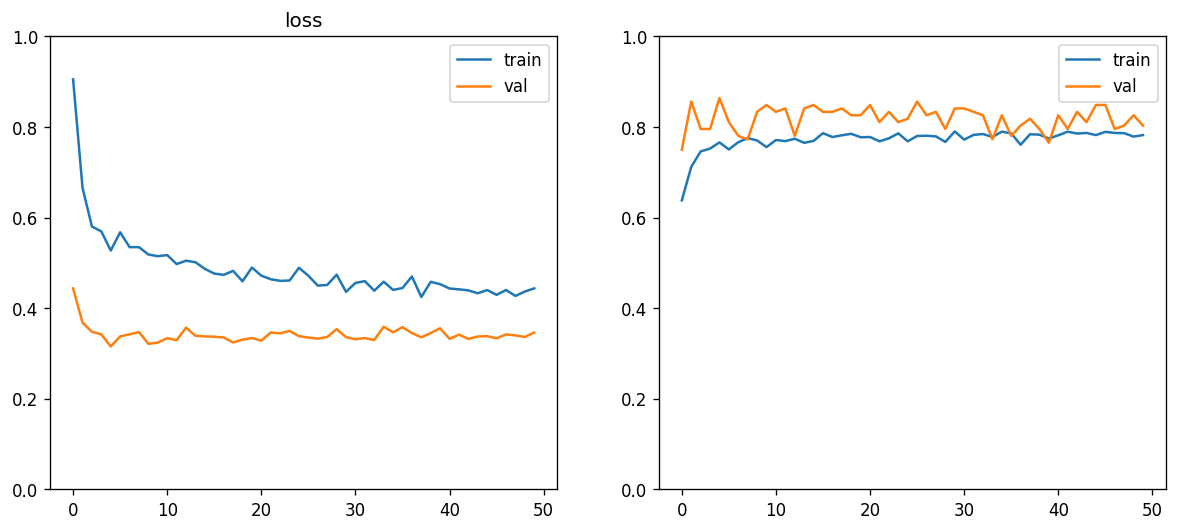

In [114]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

ax1.plot(results.history['loss'], label='train')
ax1.plot(results.history['val_loss'], label='val')
ax1.set_title('loss')
ax1.set_ylim([0, 1])
ax1.legend()

ax2.plot(results.history['binary_accuracy'], label='train')
ax2.plot(results.history['val_binary_accuracy'], label='val')
ax2.set_ylim([0, 1])
ax2.legend()

Граифики после разморозки

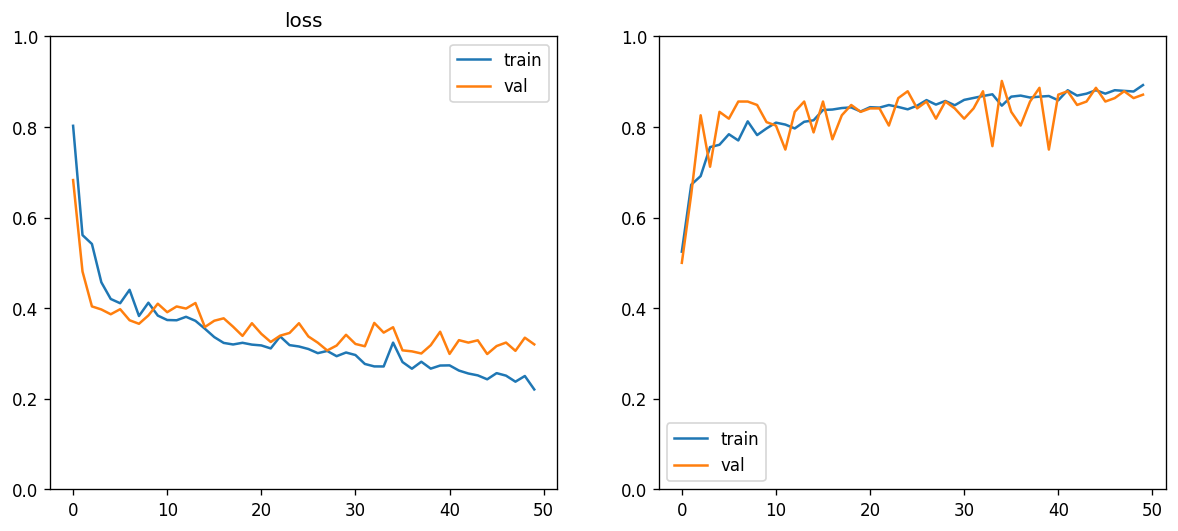

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

ax1.plot(results.history['loss'], label='train')
ax1.plot(results.history['val_loss'], label='val')
ax1.set_title('loss')
ax1.set_ylim([0, 1])
ax1.legend()

ax2.plot(results.history['binary_accuracy'], label='train')
ax2.plot(results.history['val_binary_accuracy'], label='val')
ax2.set_ylim([0, 1])
ax2.legend()

Точность до разморозки

In [101]:

model.evaluate(val_ds)

5/5 [==============================] - 1s 102ms/step - loss: 0.3110 - binary_accuracy: 0.8333


[0.31096023321151733, 0.8333333134651184]

Точность после разморозки

In [123]:
model.evaluate(val_ds)

5/5 [==============================] - 1s 98ms/step - loss: 0.3200 - binary_accuracy: 0.8712


[0.31997448205947876, 0.8712121248245239]